## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

import scipy
import scipy.sparse
import seaborn as sns

In [3]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/1TFOJ7Z80VAEFw', sep = ';', decimal=',')
# аосле того как я посмотрел на загруженные данные - понял, что надо их перезагрузить с дополнительными аргументами разделителей

In [4]:
df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [5]:
df.experimentVariant.unique()  #Немного EDA датафрейма, смотрю значения номинальной переменной

array(['Control', 'Treatment'], dtype=object)

In [6]:
df.info() # смотрю типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   value              1000 non-null   float64
 2   experimentVariant  1000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [7]:
df.isna().sum() # исследую наличие провущенные значения

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [8]:
df['value'].describe() # смотрю среднее, макс, мин, медиану целевой переменной

count    1000.000000
mean       18.674183
std       132.135045
min         6.436541
25%         9.414051
50%        10.020862
75%        10.669292
max      3000.000000
Name: value, dtype: float64

In [9]:
# По среднему, медиане (50-й процентиль) и 75 процентию и максимумам видно, 
# что в группе Treatment есть выбросы, увелицивающие среднее, но не увеличивающие медиану 
# Уже можно сделать вывод, что т-тест не подойдет для сравнения статистически значимых различий. Однако, 
# если мыслить в бизес-логике, если цель нашего  'Treatment' - увеличение value (например увеличение среднего чека), то
# мы ни в коем случае не должны удалять эти выбросы
df.groupby('experimentVariant').value.describe()

,count,mean,std,min,25%,50%,75%,max
experimentVariant,,,,,,,,
Control,500.0,10.026867,0.979377,6.436541,9.411024,10.018465,10.664879,13.130346
Treatment,500.0,27.321499,186.557011,6.436541,9.421968,10.025847,10.675721,3000.000000


In [10]:
# Смотрю максимальные значения переменных 
df.query('experimentVariant == "Control"').value.sort_values(ascending = False).head(10)

171    13.130346
195    12.817541
294    12.728285
363    12.663784
219    12.598569
415    12.511711
474    12.488277
11     12.389786
375    12.340248
440    12.241951
Name: value, dtype: float64

In [11]:
# Смотрю максимальные значения переменных 
df.query('experimentVariant == "Treatment"').value.sort_values(ascending = False).head(10)
# Обнаружил 5 "выбросов"
# В бизнес-логике возможно, что целью наших манипуляций (Treatment) и есть получение таких "единорогов", 
# поэтому удалять не буду. Также это возможно ошибка при расчетах. В любом случае повод разобраться с этим.

999    3000.000000
998    2000.000000
997    1500.000000
996    1200.000000
995    1000.000000
671      13.130346
695      12.817541
794      12.728285
863      12.663784
719      12.598569
Name: value, dtype: float64

In [12]:
# Если просуммировать все значения Treatment и Control, то мы видим, что 'Treatment' дает прирост более, чем 2,5 раза
df.query('experimentVariant == "Treatment"').value.sum(), df.query('experimentVariant == "Control"').value.sum()

(13660.749528330787, 5013.433266902148)

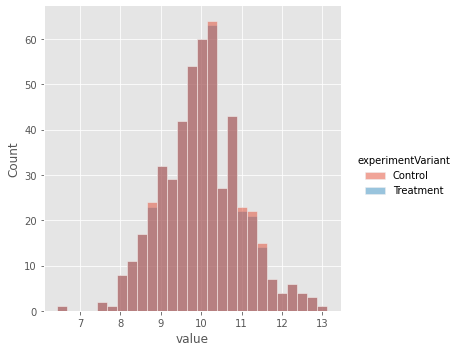

In [13]:
sns.displot(df[df['value'] < 1000], x="value", hue="experimentVariant")
# без "удаления" 5 "выбросов" выдает неинформативный график и долго его рисует

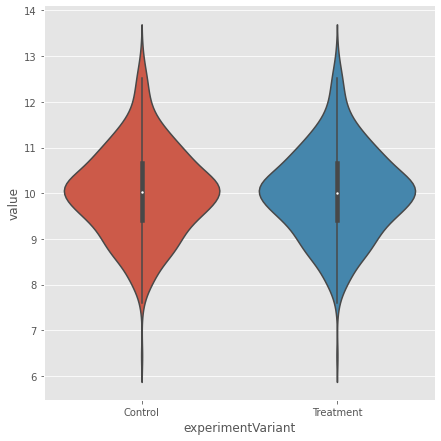

In [14]:
sns.catplot(
data=df[df['value'] < 1000], x="experimentVariant", y="value", kind="violin", height=6
)

# Без выбросов распределения двух подгрупп очень похожи

In [15]:
data_Control = df.query('experimentVariant == "Control"').value
data_Control

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
495    10.973929
496    10.261074
497     8.780090
498    11.169078
499    11.499566
Name: value, Length: 500, dtype: float64

In [16]:
data_Treatment = df.query("experimentVariant == 'Treatment'").value
data_Treatment

500      10.380495
501       9.546867
502      11.088215
503      10.147274
504       9.789808
          ...     
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, Length: 500, dtype: float64

In [3]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [86]:
def get_bootstrap(
    data_Control, # числовые значения первой выборки
    data_Treatment, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_Control.sample(
            len(data_Control), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_Treatment.sample(
            len(data_Treatment), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [87]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [88]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df1 = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

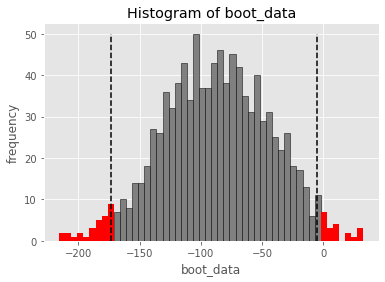

In [89]:
booted_data = get_bootstrap(df1.sample_1, df1.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [90]:
booted_data["p_value"] # альфа

0.04564731158962379

In [91]:
booted_data["quants"] # ДИ

,0
0.025,-173.270058
0.975,-4.865217


In [74]:
scipy.stats.mannwhitneyu(data_Control, data_Treatment)
# статзначимой разницы нет

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [94]:
pip install bootstrapped

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13952 sha256=d7380738e884d30085711a856c40f28f382dcd80d6e7cf85b566afbc3139f629
  Stored in directory: /mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-davydov/.cache/pip/wheels/15/55/6a/9a722f067ac4c3dfab359ed2ec7906b9cc6649156d9886bd59
Successfully built bootstrapped
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

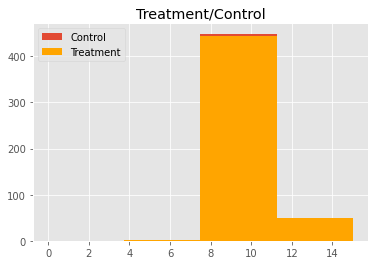

In [30]:
# Попробуем это  https://github.com/facebookarchive/bootstrapped/blob/master/examples/bootstrap_ab_testing.ipynb
bins = np.linspace(0, 15, 5)

plt.hist(data_Control, bins=bins, label='Control')
plt.hist(data_Treatment, bins=bins, label='Treatment', color='orange')
plt.title('Treatment/Control')
plt.legend()

In [25]:
print(bs_compare.percent_change(data_Treatment.mean(), data_Control.mean()))

# print(bs.bootstrap_ab(data_Treatment, data_Control, bs_stats.mean, bs_compare.percent_change))

172.48292339935554


In [22]:
t1_Treatment = scipy.sparse.csr_matrix(data_Treatment)
t2_Control = scipy.sparse.csr_matrix(data_Control)
# Сначала пердыдущий запрос мне выдал вот такую ошибку "ValueError: The arrays must either be of type scipy.sparse.csr_matrix or numpy.array"
# пришлось преобразовать

In [23]:
print(bs.bootstrap_ab(t1_Treatment, t2_Control, bs_stats.mean, bs_compare.percent_change))

172.48292339935557    (-9.109606842253868, 315.0245672769896)


In [27]:
t1_Treatment # посмотрел что это такое

<1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 500 stored elements in Compressed Sparse Row format>

In [29]:
print(bs_compare.percent_change(t1_Treatment.sum(), t2_Control.sum()))

print(bs.bootstrap_ab(
    t1_Treatment, 
    t2_Control, 
    stat_func=bs_stats.sum,
    compare_func=bs_compare.percent_change
))
# Доверительные интервалы пересекают 0, статзначимой разницы средних нет

172.48292339935546
172.48292339935554    (-11.243335427925786, 314.84645772071264)


In [75]:
scipy.stats.ttest_ind(data_Treatment, data_Control)
# с "выбросами" показывает статистически значимую разницу

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [17]:
# Ради интереса - удалю "выбросы" и 5 самых больших значений из Control нруппы, 
# чтобы выборки были равны по числу наблюдений (условие проведения т-теста)
t3 = data_Treatment.sort_values()[0:495]
t4 = data_Control.sort_values()[0:495]

In [18]:
scipy.stats.ttest_ind(t3, t4)
# без "выбросов" статистически значимой разницы нет

Ttest_indResult(statistic=0.3721841929413442, pvalue=0.7098355286845134)

In [20]:
t3.sum(), t4.sum()
# суммы всех значений без 5 "выбросов" в двух подгруппах почти равны, в первой стала ниже, хотя до этого сотавляла 13 тысяч

(4960.749528330789, 4949.494742541373)

In [21]:
t3.mean(), t4.mean()
# Среднее значение также уменьшилась с 27 до 10 и стало сопоставимым со средним второй выборки

(10.021716218850079, 9.998979277861359)

Выводы:
Надо разбираться с 5 "выбросами" - это ошибка или наша цель?
Желательно проверить появления выбросов в "генеральной совокупности", 
но тогда надо сравнивать не средние, а вероятность наличия этих выбросов в генеральной совокупности.


Если цель - исследовать различия, то т-тест показал неустойчивость к выбросам


P.S. Хотя, конечно, понятно, что это сгененрированный датасет с искуственно добавленными 5 резко выделяющимися значениями, а не реальные данные.
